# Atlas 14 Spatial Variance Analysis

This notebook demonstrates how to analyze spatial variability of NOAA Atlas 14 precipitation frequency estimates within a HEC-RAS model domain. This helps determine whether uniform rainfall assumptions are appropriate for rain-on-grid modeling.

**Key Features:**
- Remote access to NOAA Atlas 14 CONUS data via HTTP range requests (99.9% data reduction)
- Integration with HEC-RAS 2D flow area extents
- Variance statistics (min, max, mean, range) for precipitation frequency
- Decision support for uniform vs. spatially distributed rainfall

**When to use this analysis:**
- Before rain-on-grid modeling to assess uniformity assumptions
- For large model domains (>100 sq mi) where spatial variance may be significant
- When comparing multiple design storm events

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## 1. Direct Bounds Query

First, let's demonstrate querying Atlas 14 data for a specific geographic area without a HEC-RAS project. This is useful for exploring data availability and understanding precipitation patterns.

In [2]:
from ras_commander.precip import Atlas14Grid

# Query Atlas 14 data for Houston, TX area
# This uses HTTP range requests to download only the needed data
pfe = Atlas14Grid.get_pfe_for_bounds(
    bounds=(-95.5, 29.5, -95.0, 30.0),  # (west, south, east, north)
    durations=[6, 12, 24],
    return_periods=[10, 50, 100],
    buffer_percent=0
)

print(f"Bounds: {pfe['bounds']}")
print(f"Grid dimensions: {pfe['lat'].shape[0]} x {pfe['lon'].shape[0]}")
print(f"Durations: {pfe['durations']} hours")
print(f"Return periods: {pfe['return_periods']} years")

2026-01-14 11:39:45 - ras_commander.precip.Atlas14Grid - INFO - Loading Atlas 14 coordinate arrays from remote file...
2026-01-14 11:39:45 - ras_commander.precip.Atlas14Grid - INFO - Loading Atlas 14 coordinate arrays from remote file...
2026-01-14 11:39:56 - ras_commander.precip.Atlas14Grid - INFO - Loaded coordinates: lat=3121, lon=7081, ari=9
2026-01-14 11:39:56 - ras_commander.precip.Atlas14Grid - INFO - Loaded coordinates: lat=3121, lon=7081, ari=9
2026-01-14 11:39:56 - ras_commander.precip.Atlas14Grid - INFO - Extracting Atlas 14 data for bounds (-95.5000, 29.5000, -95.0000, 30.0000): lat[661:721], lon[3541:3601]
2026-01-14 11:39:56 - ras_commander.precip.Atlas14Grid - INFO - Extracting Atlas 14 data for bounds (-95.5000, 29.5000, -95.0000, 30.0000): lat[661:721], lon[3541:3601]
2026-01-14 11:40:02 - ras_commander.precip.Atlas14Grid - INFO - Data transfer: 189.8 KB (vs 1138.1 MB full grid, 100.0% reduction)
2026-01-14 11:40:02 - ras_commander.precip.Atlas14Grid - INFO - Data tran

Bounds: (-95.5, 29.5, -95.0, 30.0)
Grid dimensions: 60 x 60
Durations: [6, 12, 24] hours
Return periods: [10, 50, 100] years


In [3]:
import numpy as np

# Examine the 100-year, 24-hour precipitation
data_24hr = pfe['pfe_24hr']
ari = pfe['ari']

# Find index for 100-year (ARI dimension is last)
ari_100_idx = np.argmin(np.abs(ari - 100))

data_100yr_24hr = data_24hr[:, :, ari_100_idx]

print(f"100-year, 24-hour precipitation:")
print(f"  Min: {np.nanmin(data_100yr_24hr):.2f} inches")
print(f"  Max: {np.nanmax(data_100yr_24hr):.2f} inches")
print(f"  Mean: {np.nanmean(data_100yr_24hr):.2f} inches")
print(f"  Range: {np.nanmax(data_100yr_24hr) - np.nanmin(data_100yr_24hr):.2f} inches")
print(f"  Range %: {(np.nanmax(data_100yr_24hr) - np.nanmin(data_100yr_24hr)) / np.nanmin(data_100yr_24hr) * 100:.1f}%")

100-year, 24-hour precipitation:
  Min: 16.49 inches
  Max: 18.20 inches
  Mean: 17.46 inches
  Range: 1.71 inches
  Range %: 10.4%


## 2. Visualize Spatial Variability

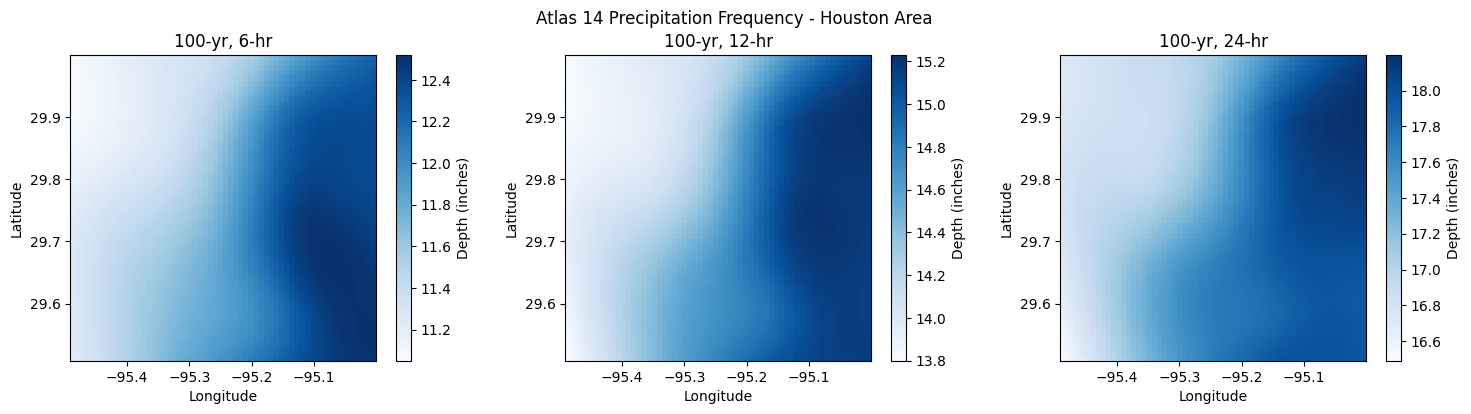

In [4]:
import matplotlib.pyplot as plt

# Create a simple visualization of spatial variability
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, duration in enumerate([6, 12, 24]):
    data = pfe[f'pfe_{duration}hr'][:, :, ari_100_idx]
    
    ax = axes[idx]
    im = ax.imshow(data, origin='lower', 
                   extent=[pfe['lon'].min(), pfe['lon'].max(),
                          pfe['lat'].min(), pfe['lat'].max()],
                   cmap='Blues')
    plt.colorbar(im, ax=ax, label='Depth (inches)')
    ax.set_title(f'100-yr, {duration}-hr')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.suptitle('Atlas 14 Precipitation Frequency - Houston Area', fontsize=12)
plt.tight_layout()
plt.show()

## 3. Point Query for Single Location

For quick lookups at a specific location:

In [5]:
# Get PFE for a single point (downtown Houston)
point_df = Atlas14Grid.get_point_pfe(
    lat=29.76,
    lon=-95.37,
    durations=[6, 12, 24],
    return_periods=[10, 25, 50, 100, 500]
)

print("Point Precipitation Frequency Estimates (Houston, TX):")
point_df_pivot = point_df.pivot(
    index='duration_hr',
    columns='return_period_yr',
    values='depth_inches'
)
print(point_df_pivot.round(2))

2026-01-14 11:40:02 - ras_commander.precip.Atlas14Grid - INFO - Point (29.7600, -95.3700) -> nearest grid (29.7583, -95.3667)
2026-01-14 11:40:02 - ras_commander.precip.Atlas14Grid - INFO - Point (29.7600, -95.3700) -> nearest grid (29.7583, -95.3667)


Point Precipitation Frequency Estimates (Houston, TX):
return_period_yr   10     25     50     100    500
duration_hr                                       
6                 6.15   7.97   9.56  11.41  16.95
12                7.39   9.69  11.72  14.11  21.22
24                8.75  11.56  14.07  17.00  25.46


## 4. Integration with HEC-RAS Project

The most powerful feature is automatic integration with HEC-RAS projects. The `get_pfe_from_project()` method extracts the extent from your geometry HDF file and downloads only the needed data.

**Note:** This example uses a sample project. Replace with your actual project path.

In [6]:
from ras_commander import RasExamples, init_ras_project

# Extract an example project with 2D flow areas
project_path = RasExamples.extract_project("BaldEagleCrkMulti2D", suffix="atlas14_variance")
print(f"Project extracted to: {project_path}")

# Initialize project
ras = init_ras_project(project_path, ras_version="6.6")
print(f"\nProject: {ras.project_name}")
print(f"Geometry files: {len(ras.geom_df)}")

2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-14 11:40:12 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' 

Project extracted to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance

Project: BaldEagleDamBrk
Geometry files: 10


In [7]:
from pathlib import Path

# Find the geometry HDF file
geom_hdfs = list(project_path.glob("*.g*.hdf"))
if geom_hdfs:
    geom_hdf = geom_hdfs[0]
    print(f"Geometry HDF: {geom_hdf.name}")
else:
    print("No geometry HDF found")
    geom_hdf = None

Geometry HDF: BaldEagleDamBrk.g01.hdf


In [8]:
if geom_hdf:
    # Get Atlas 14 data using 2D flow area extent
    pfe_project = Atlas14Grid.get_pfe_from_project(
        geom_hdf=geom_hdf,
        extent_source="2d_flow_area",  # Use 2D flow areas
        durations=[6, 12, 24],
        return_periods=[10, 25, 50, 100],
        buffer_percent=10.0,
        ras_object=ras
    )
    
    print(f"Extent source: {pfe_project['extent_source']}")
    print(f"Bounds: {pfe_project['bounds']}")
    print(f"Grid dimensions: {pfe_project['lat'].shape[0]} x {pfe_project['lon'].shape[0]}")
    if 'mesh_area_names' in pfe_project:
        print(f"2D Areas: {pfe_project['mesh_area_names']}")

2026-01-14 11:40:13 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-14 11:40:13 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-14 11:40:13 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\BaldEagleDamBrk.g01.hdf
2026-01-14 11:40:13 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\Bald

Extent source: 2d_flow_area
Bounds: (np.float64(-77.6628709426164), np.float64(41.03210835058915), np.float64(-77.2970389985552), np.float64(41.197997263936664))
Grid dimensions: 20 x 44
2D Areas: ['BaldEagleCr']


## 5. Full Variance Analysis

The `Atlas14Variance` class provides comprehensive variance analysis:

In [9]:
from ras_commander.precip import Atlas14Variance

if geom_hdf:
    # Run full variance analysis
    results = Atlas14Variance.analyze(
        geom_hdf=geom_hdf,
        durations=[6, 12, 24],
        return_periods=[10, 25, 50, 100],
        extent_source="2d_flow_area",
        variance_denominator='min',  # range_pct = (max-min)/min * 100
        ras_object=ras
    )
    
    print("\nVariance Analysis Results:")
    print(results.to_string(index=False))

2026-01-14 11:40:26 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-14 11:40:26 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-14 11:40:26 - ras_commander.precip.Atlas14Variance - INFO - Durations: [6, 12, 24] hours, Return periods: [10, 25, 50, 100] years
2026-01-14 11:40:26 - ras_commander.precip.Atlas14Variance - INFO - Durations: [6, 12, 24] hours, Return periods: [10, 25, 50, 100] years
2026-01-14 11:40:26 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-14 11:40:26 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2


Variance Analysis Results:
  mesh_area  duration_hr  return_period_yr  min_inches  max_inches  mean_inches  range_inches  range_pct  cell_count
BaldEagleCr            6                10        2.49        2.59     2.534113          0.10   4.016060         124
BaldEagleCr            6                25        2.95        3.08     3.003226          0.13   4.406775         124
BaldEagleCr            6                50        3.31        3.49     3.388387          0.18   5.438069         124
BaldEagleCr            6               100        3.68        3.94     3.794839          0.26   7.065217         124
BaldEagleCr           12                10        3.11        3.22     3.161451          0.11   3.536982         124
BaldEagleCr           12                25        3.69        3.85     3.762258          0.16   4.336046         124
BaldEagleCr           12                50        4.17        4.38     4.263307          0.21   5.035972         124
BaldEagleCr           12            

In [10]:
if geom_hdf and not results.empty:
    # Check if uniform rainfall is appropriate
    ok, message = Atlas14Variance.is_uniform_rainfall_appropriate(results, threshold_pct=10.0)
    
    print(f"\n{'✓' if ok else '⚠️'} {message}")
    
    # Show highest variance events
    if not ok:
        print("\nHighest variance events:")
        high_var = results.nlargest(3, 'range_pct')[['duration_hr', 'return_period_yr', 'min_inches', 'max_inches', 'range_pct']]
        print(high_var.to_string(index=False))


✓ Uniform rainfall appropriate. Maximum variance is 7.1% (threshold: 10.0%)


## 6. Visualize Variance by Duration and AEP

Let's create a detailed visualization showing how variance changes across different storm durations and Annual Exceedance Probability (AEP) intervals.

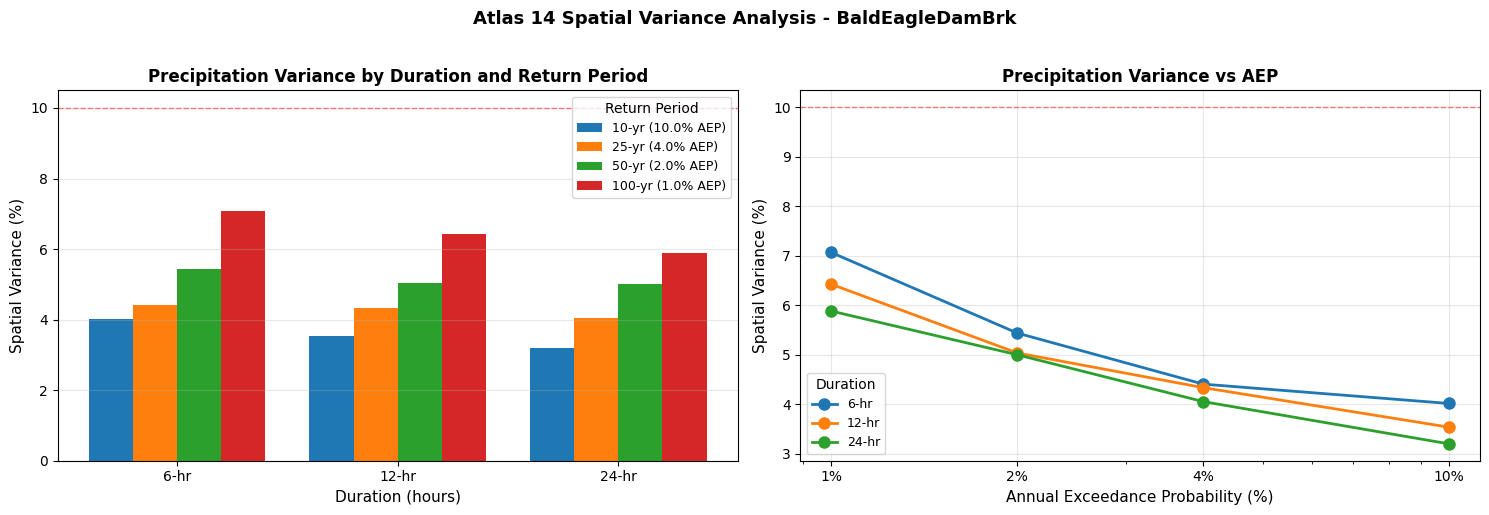


Variance Summary by Duration:
            range_pct             range_inches            
                  min   max  mean          min   max  mean
duration_hr                                               
6                4.02  7.07  5.23         0.10  0.26  0.17
12               3.54  6.42  4.83         0.11  0.30  0.19
24               3.20  5.88  4.53         0.12  0.33  0.22


Variance Summary by Return Period (AEP):
                         range_pct             range_inches            
                               min   max  mean          min   max  mean
return_period_yr aep_pct                                               
10               10.0         3.20  4.02  3.58         0.10  0.12  0.11
25               4.0          4.05  4.41  4.27         0.13  0.18  0.16
50               2.0          5.00  5.44  5.16         0.18  0.25  0.21
100              1.0          5.88  7.07  6.46         0.26  0.33  0.30


In [11]:
if geom_hdf and not results.empty:
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Calculate AEP from return period (AEP = 1/return_period * 100 for percentage)
    results_plot = results.copy()
    results_plot['aep_pct'] = (1 / results_plot['return_period_yr'] * 100).round(2)
    
    # Plot 1: Range % by Duration (grouped by return period)
    durations = sorted(results_plot['duration_hr'].unique())
    return_periods = sorted(results_plot['return_period_yr'].unique())
    
    x = np.arange(len(durations))
    width = 0.2
    
    for i, rp in enumerate(return_periods):
        data = results_plot[results_plot['return_period_yr'] == rp]
        data_sorted = data.sort_values('duration_hr')
        aep = (1/rp * 100)
        offset = (i - len(return_periods)/2 + 0.5) * width
        ax1.bar(x + offset, data_sorted['range_pct'], width, 
                label=f'{rp}-yr ({aep:.1f}% AEP)')
    
    ax1.set_xlabel('Duration (hours)', fontsize=11)
    ax1.set_ylabel('Spatial Variance (%)', fontsize=11)
    ax1.set_title('Precipitation Variance by Duration and Return Period', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{int(d)}-hr' for d in durations])
    ax1.legend(title='Return Period', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=10, color='red', linestyle='--', alpha=0.5, linewidth=1, label='10% threshold')
    
    # Plot 2: Range % vs AEP (lines for each duration)
    for duration in durations:
        data = results_plot[results_plot['duration_hr'] == duration]
        data_sorted = data.sort_values('aep_pct', ascending=False)  # Sort by AEP descending
        ax2.plot(data_sorted['aep_pct'], data_sorted['range_pct'], 
                marker='o', linewidth=2, markersize=8, label=f'{int(duration)}-hr')
    
    ax2.set_xlabel('Annual Exceedance Probability (%)', fontsize=11)
    ax2.set_ylabel('Spatial Variance (%)', fontsize=11)
    ax2.set_title('Precipitation Variance vs AEP', fontsize=12, fontweight='bold')
    ax2.legend(title='Duration', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=10, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax2.set_xscale('log')  # Log scale for AEP (common, moderate, rare events)
    
    # Format x-axis for common AEP values
    ax2.set_xticks([1, 2, 4, 10])
    ax2.set_xticklabels(['1%', '2%', '4%', '10%'])
    
    plt.suptitle(f'Atlas 14 Spatial Variance Analysis - {ras.project_name}', 
                 fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nVariance Summary by Duration:")
    print("=" * 70)
    summary = results_plot.groupby('duration_hr').agg({
        'range_pct': ['min', 'max', 'mean'],
        'range_inches': ['min', 'max', 'mean']
    }).round(2)
    print(summary)
    
    print("\n\nVariance Summary by Return Period (AEP):")
    print("=" * 70)
    summary2 = results_plot.groupby(['return_period_yr', 'aep_pct']).agg({
        'range_pct': ['min', 'max', 'mean'],
        'range_inches': ['min', 'max', 'mean']
    }).round(2)
    print(summary2)

## 7. Quick Variance Check

For a rapid assessment using a single representative event (default: 100-year, 24-hour):

In [12]:
if geom_hdf:
    # Quick check for 100-year, 24-hour
    quick_stats = Atlas14Variance.analyze_quick(
        geom_hdf=geom_hdf,
        duration=24,
        return_period=100
    )
    
    print("Quick Variance Check (100-yr, 24-hr):")
    print(f"  Min: {quick_stats['min']:.2f} inches")
    print(f"  Max: {quick_stats['max']:.2f} inches")
    print(f"  Mean: {quick_stats['mean']:.2f} inches")
    print(f"  Range: {quick_stats['range']:.2f} inches")
    print(f"  Range %: {quick_stats['range_pct']:.1f}%")
    
    if quick_stats['range_pct'] > 10:
        print("\n⚠️ Consider using spatially variable rainfall")
    else:
        print("\n✓ Uniform rainfall is likely appropriate")

2026-01-14 11:40:34 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-14 11:40:34 - ras_commander.precip.Atlas14Variance - INFO - Starting Atlas 14 variance analysis for BaldEagleDamBrk.g01.hdf
2026-01-14 11:40:34 - ras_commander.precip.Atlas14Variance - INFO - Durations: [24] hours, Return periods: [100] years
2026-01-14 11:40:34 - ras_commander.precip.Atlas14Variance - INFO - Durations: [24] hours, Return periods: [100] years
2026-01-14 11:40:34 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\BaldEagleDamBrk.g01.hdf using 2d_flow_area
2026-01-14 11:40:34 - ras_commander.precip.Atlas14Grid - INFO - Extracting extent from C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\BaldEagleDamBrk.g01

Quick Variance Check (100-yr, 24-hr):
  Min: 5.61 inches
  Max: 5.94 inches
  Mean: 5.75 inches
  Range: 0.33 inches
  Range %: 5.9%

✓ Uniform rainfall is likely appropriate


## 8. Generate Report

Export results with plots for engineering review:

2026-01-14 11:40:37 - ras_commander.precip.Atlas14Variance - INFO - Saved statistics to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\Atlas14_Variance_Report\variance_statistics.csv
2026-01-14 11:40:37 - ras_commander.precip.Atlas14Variance - INFO - Saved statistics to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\Atlas14_Variance_Report\variance_statistics.csv
2026-01-14 11:40:37 - ras_commander.precip.Atlas14Variance - INFO - Saved summary to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\Atlas14_Variance_Report\variance_summary.csv
2026-01-14 11:40:37 - ras_commander.precip.Atlas14Variance - INFO - Saved summary to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_at


Report generated at: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_atlas14_variance\Atlas14_Variance_Report

Files created:
  - variance_by_duration.png
  - variance_heatmap.png
  - variance_statistics.csv
  - variance_summary.csv

Variance Plots

Variance by Duration:


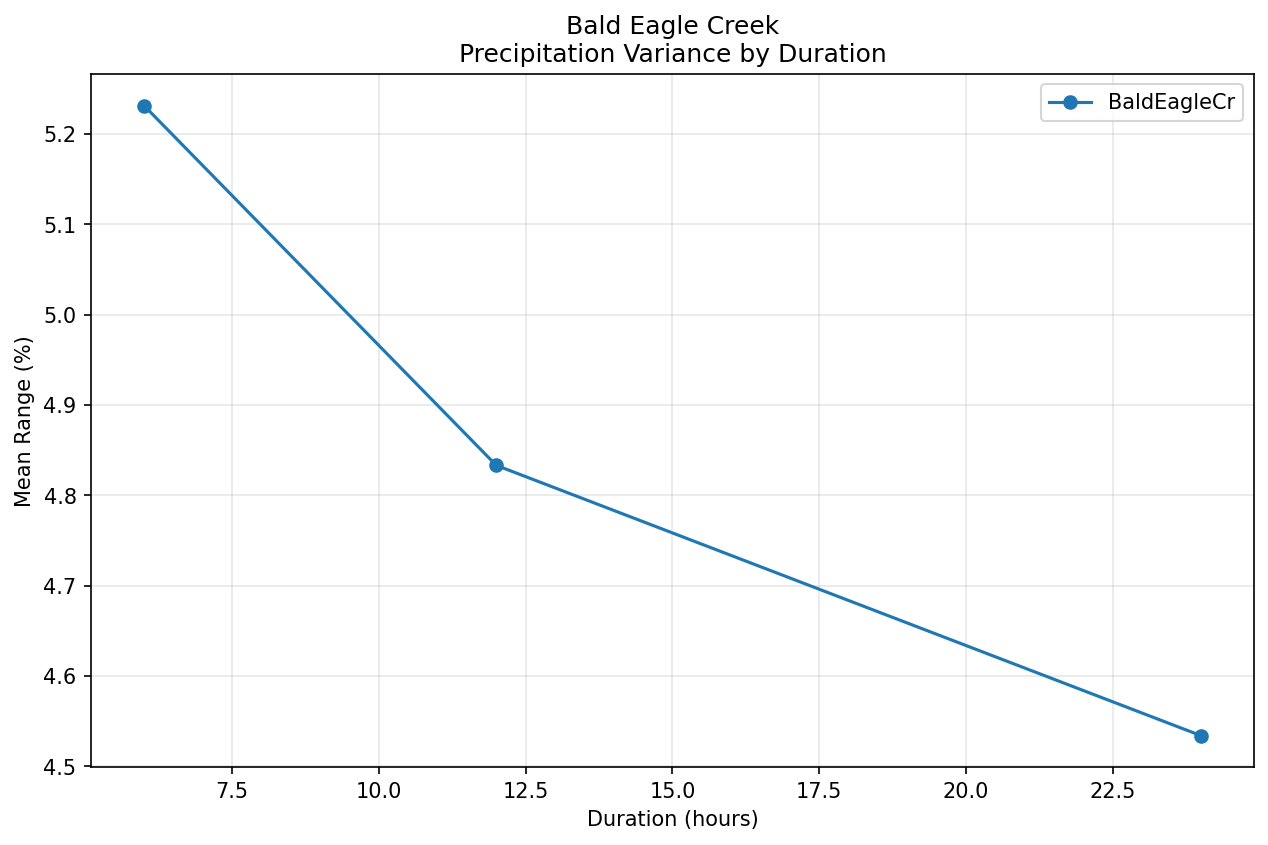


Variance Heatmap:


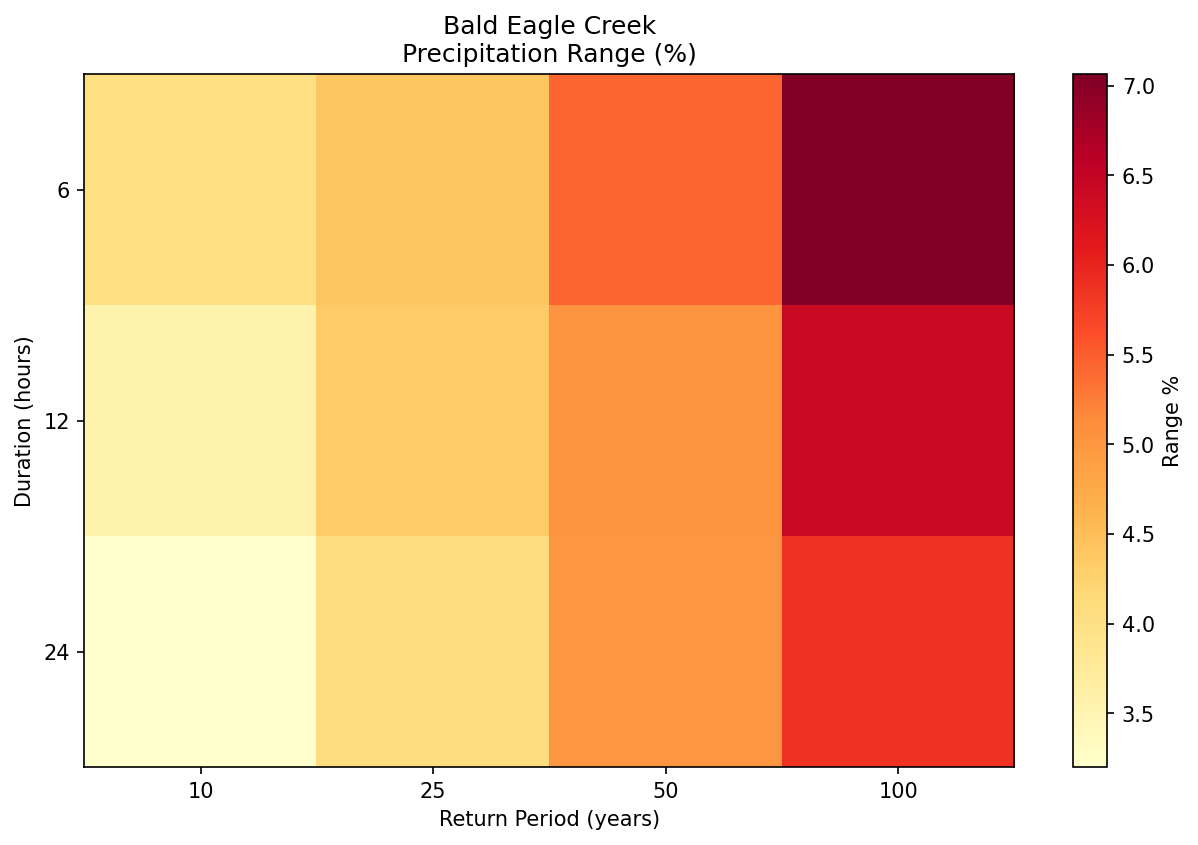

In [13]:
if geom_hdf and not results.empty:
    output_dir = project_path / "Atlas14_Variance_Report"
    
    report_dir = Atlas14Variance.generate_report(
        results_df=results,
        output_dir=output_dir,
        project_name="Bald Eagle Creek",
        include_plots=True
    )
    
    print(f"\nReport generated at: {report_dir}")
    print("\nFiles created:")
    for f in report_dir.glob("*"):
        print(f"  - {f.name}")
    
    # Display plots inline
    from IPython.display import Image, display
    import matplotlib.pyplot as plt
    
    print("\n" + "="*80)
    print("Variance Plots")
    print("="*80)
    
    # Show variance by duration plot
    var_duration_plot = report_dir / "variance_by_duration.png"
    if var_duration_plot.exists():
        print("\nVariance by Duration:")
        display(Image(filename=str(var_duration_plot)))
    
    # Show heatmap
    heatmap_plot = report_dir / "variance_heatmap.png"
    if heatmap_plot.exists():
        print("\nVariance Heatmap:")
        display(Image(filename=str(heatmap_plot)))

## 9. Cleanup

In [14]:
# Clear the coordinate cache to free memory
Atlas14Grid.clear_cache()
print("Cache cleared")

# Optionally clean up extracted project
# import shutil
# shutil.rmtree(project_path.parent, ignore_errors=True)

Cache cleared


## Summary

This notebook demonstrated:

1. **Direct Bounds Query** - Get Atlas 14 data for any geographic area
2. **Point Query** - Quick lookup for a single location
3. **HEC-RAS Integration** - Automatic extent extraction from 2D flow areas
4. **Variance Analysis** - Calculate min/max/mean/range statistics
5. **Decision Support** - Determine if uniform rainfall is appropriate
6. **Report Generation** - Export results for engineering review

**Key Takeaways:**
- Range percentage > 10% suggests spatially variable rainfall should be considered
- The analysis uses HTTP range requests to minimize data transfer (~99.9% reduction)
- All CONUS locations are supported (24°N-50°N, -125°W to -66°W)

**References:**
- [NOAA Atlas 14](https://hdsc.nws.noaa.gov/pfds/)
- [Precipitation Frequency Data Server](https://hdsc.nws.noaa.gov/pfds/pfds_gis.html)